In [1]:
# Loading in Libraries
rm(list = ls())
library(tidyverse)
library(tidymodels)
library(ranger)
library(janitor)

# Setting seed for reproducibility
set.seed(123)

# Loading in Data
url <- 'https://github.com/MatildaBae/dsci-100-2023W1-group45/raw/main/data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv'
diab_data <- read_csv(url)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# Formatting column classes appropriately
age_levels <- c('[18,24]', 
                '[25,29]', 
                '[30,34]', 
                '[35,39]', 
                '[40,44]', 
                '[45,49]', 
                '[50,54]', 
                '[55,59]', 
                '[60,64]', 
                '[65,69]', 
                '[70,74]', 
                '[75,79]', 
                '[79,∞)')

diab_data <- diab_data %>% 
        mutate(across(everything(), as_factor)) %>%
        mutate(Diabetes_binary = fct_recode(Diabetes_binary, 'Case' = '1', 'Control' = '0')) %>%
        mutate(Diabetes_binary = factor(Diabetes_binary, levels = c('Case', 'Control'))) %>%
        mutate(Sex = fct_recode(Sex, 'Female' = '0', 'Male' = '1')) %>%
        mutate(Sex = factor(Sex, levels = c('Male', 'Female'))) %>%
        mutate(Age = fct_recode(Age, 
                                '[18,24]' = '1',
                                '[25,29]' = '2',
                                '[30,34]' = '3',
                                '[35,39]' = '4',
                                '[40,44]' = '5',
                                '[45,49]' = '6',
                                '[50,54]' = '7',
                                '[55,59]' = '8',
                                '[60,64]' = '9',
                                '[65,69]' = '10',
                                '[70,74]' = '11',
                                '[75,79]' = '12',
                                '[79,∞)' = '13')) %>%
        mutate(Age = factor(Age, levels = age_levels)) %>%
        mutate(BMI = as.numeric(BMI),
               MentHlth = as.numeric(MentHlth),
               GenHlth = as.numeric(GenHlth)) %>%
        clean_names()

In [4]:
# Subsampling data to 1000 observations (500 from each class)
diab_samp <- diab_data %>% 
        group_by(diabetes_binary) %>%
        slice_sample(n = 500) %>%
        ungroup()

write_csv(file = 'diabetes_subsampled.csv', diab_samp)

# Exploring BMI data
summary_bmi <- diab_samp %>% 
  select(diabetes_binary, bmi) %>%
  group_by(diabetes_binary) %>%
  summarize(mean_bmi = mean(bmi),
            sd_bmi = sd(bmi))
summary_bmi

mean_bmi_case <- summary_bmi %>% 
  filter(diabetes_binary == 'Case') %>% 
  pull(mean_bmi)
mean_bmi_control <- summary_bmi %>% 
  filter(diabetes_binary == 'Control') %>% 
  pull(mean_bmi)


diabetes_binary,mean_bmi,sd_bmi
<fct>,<dbl>,<dbl>
Case,21.224,6.852718
Control,17.062,6.511140


Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”


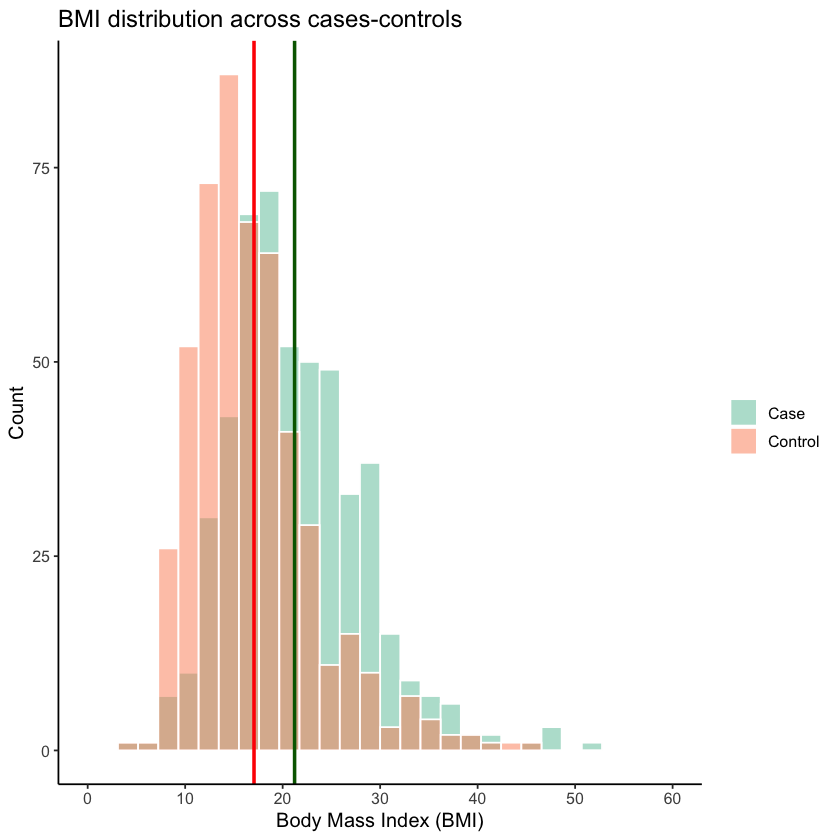

In [5]:
# Plotting BMI frequency
bmi_plot <- diab_samp %>%
  ggplot(aes(x = bmi, fill = diabetes_binary)) +
  geom_histogram(bins = 30, 
                 color = 'white',
                 linewidth = 0.5,
                 alpha = 0.5,
                 position = 'identity') +
  geom_vline(xintercept = mean_bmi_case, color = 'darkgreen', linewidth = 1) +
  geom_vline(xintercept = mean_bmi_control, color = 'red', linewidth = 1) +
  scale_x_continuous(limits = c(0, 60),
                     breaks = seq(0, 60, 10)) +
  labs(x = 'Body Mass Index (BMI)', 
       y = 'Count',
       fill = '') +
  ggtitle('BMI distribution across cases-controls') +
  scale_fill_brewer(palette = 'Set2') +
  theme_classic() +
  theme(text = element_text(size = 12))
bmi_plot


In [6]:
# General and Mental Health scores
diab_samp %>% select(diabetes_binary, gen_hlth, ment_hlth) %>%
  group_by(diabetes_binary) %>%
  summarize(across(gen_hlth:ment_hlth, mean, .names = 'mean_{.col}'),
            across(gen_hlth:ment_hlth, sd, .names = 'sd_{.col}'))


diabetes_binary,mean_gen_hlth,mean_ment_hlth,sd_gen_hlth,sd_ment_hlth
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Case,3.314,4.978,1.0066930,8.563889
Control,2.362,3.940,0.9984738,7.429050


diabetes_binary,age,n
<fct>,<fct>,<int>
Case,"[18,24]",3
Case,"[25,29]",6
Case,"[30,34]",5
Case,"[35,39]",10
Case,"[40,44]",19
Case,"[45,49]",18
Case,"[50,54]",37
Case,"[55,59]",71
Case,"[60,64]",99


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '[79,∞)' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '[79,∞)' in 'mbcsToSbcs': dot substituted for <88>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '[79,∞)' in 'mbcsToSbcs': dot substituted for <9e>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '[79,∞)' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '[79,∞)' in 'mbcsToSbcs': dot substituted for <88>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '[79,∞)' in 'mbcsToSbcs': dot substituted for <9e>”
Warning message in grid.Call(C_textBounds, as.graphicsAnno

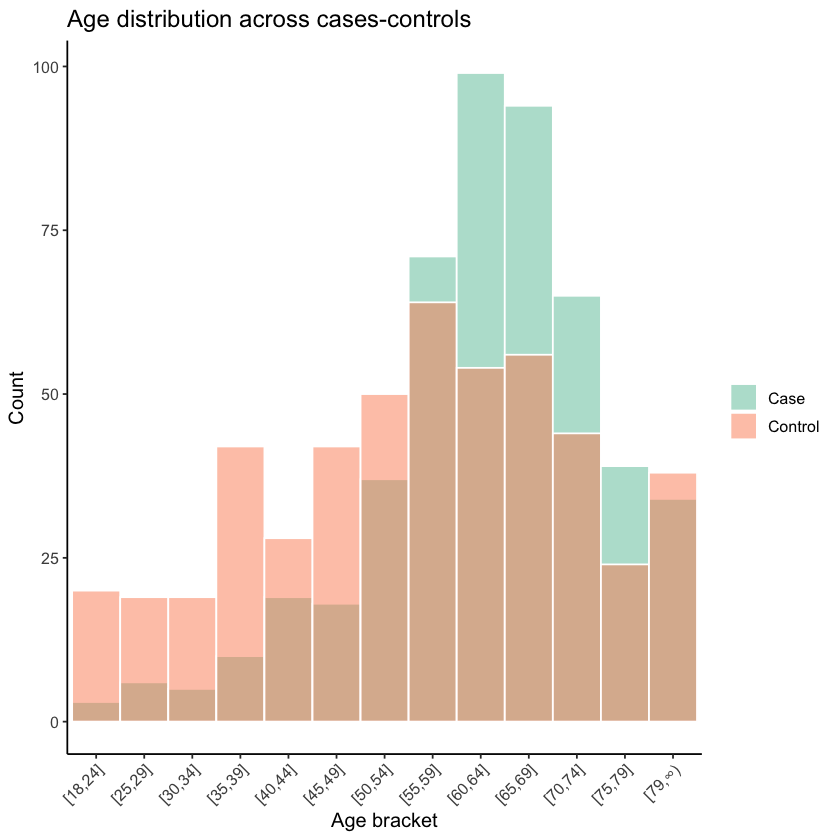

In [7]:
# Plotting age data
diab_samp %>% 
  select(diabetes_binary, age) %>%
  count(diabetes_binary, age) 

age_plot <- diab_samp %>%
  select(diabetes_binary, age) %>%
  ggplot(aes(x = age, fill = diabetes_binary)) +
  geom_bar(stat = 'count', 
           position = 'identity',
           color = 'white',
           alpha = 0.5,
           width = 1) +
  labs(x = 'Age bracket',
       y = 'Count',
       fill = '') +
  ggtitle('Age distribution across cases-controls') +
  scale_fill_brewer(palette = 'Set2') +
  theme_classic() +
  theme(text = element_text(size = 12),
        panel.grid.major = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1))
age_plot


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '[79,∞)' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '[79,∞)' in 'mbcsToSbcs': dot substituted for <88>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '[79,∞)' in 'mbcsToSbcs': dot substituted for <9e>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '[79,∞)' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '[79,∞)' in 'mbcsToSbcs': dot substituted for <88>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '[79,∞)' in 'mbcsToSbcs': dot substituted for <9e>”
Warning message in grid.Call(C_textBounds, as.graphicsAnno

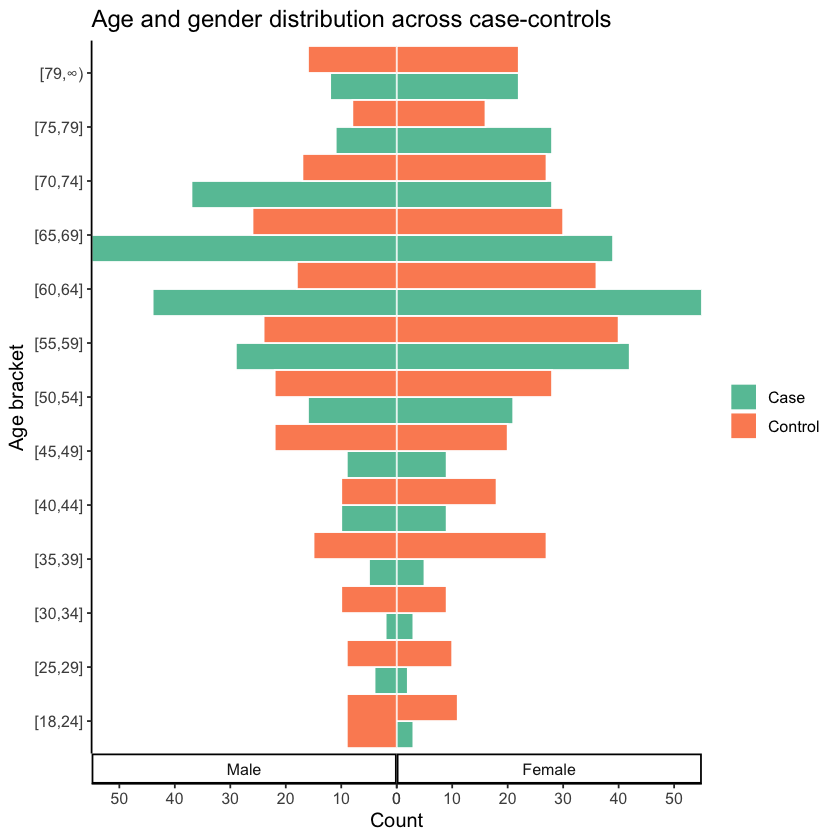

In [8]:
# Population plot
diab_samp %>% 
  count(diabetes_binary, 
        age, 
        sex) %>%
  mutate(n = ifelse(sex == 'Male', 
                    n * -1, 
                    n)) %>%
  ggplot(aes(x = age, 
             y = n, 
             fill = diabetes_binary)) +
  geom_bar(stat = 'identity', 
           position = 'dodge',
           color = 'white',
           width = 1) +
  labs(x = 'Age bracket', 
       y = 'Count',
       fill = '') +
  ggtitle('Age and gender distribution across case-controls') +
  coord_flip() +
  scale_fill_brewer(palette = 'Set2') +
  theme_classic() +
  scale_y_continuous(labels = abs,
                     expand = c(0,0)) +
  facet_wrap(~sex, 
             strip.position = 'bottom', 
             scale = 'free_x') +
  theme(text = element_text(size = 12), 
        panel.spacing.x = unit(0, 'pt'))


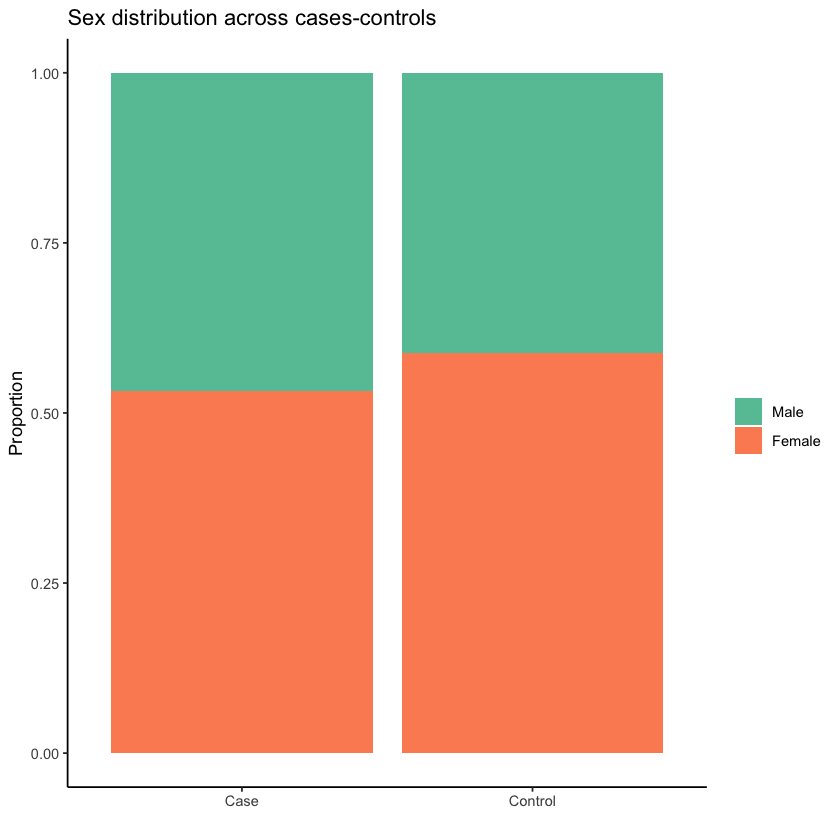

In [9]:
# Sex data
diab_samp %>% 
  count(diabetes_binary, sex) %>%
  ggplot(aes(x = diabetes_binary,
             y = n,
             fill = sex)) +
  geom_bar(stat = 'identity', 
           position = 'fill') +
  labs(x = '',
       y = 'Proportion',
       fill = '') +
  ggtitle('Sex distribution across cases-controls') +
  scale_fill_brewer(palette = 'Set2') +
  theme_classic()


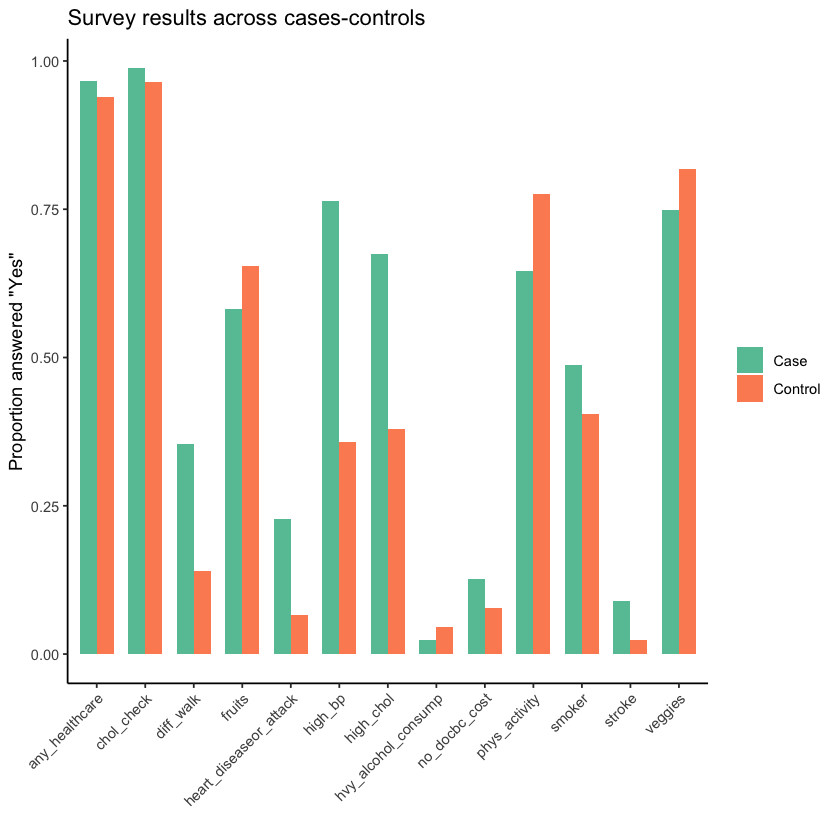

In [10]:
# Looking at binary survey data
diab_summary <- diab_samp %>% 
  select(-sex) %>%
  group_by(diabetes_binary) %>% 
  summarize(across(where(~ is.factor(.x) && length(unique(.x)) == 2), ~ sum(. == "1") / n(), .names = '{.col}'))

survey_plot <- diab_summary %>%
  pivot_longer(!diabetes_binary) %>%
  ggplot(aes(x = name, y = value, fill = diabetes_binary)) +
  geom_bar(stat = 'identity', position = 'dodge', width = 0.7) +
  labs(x = '', y = 'Proportion answered "Yes"', fill = '') +
  ggtitle("Survey results across cases-controls") +
  scale_fill_brewer(palette = 'Set2') +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
survey_plot


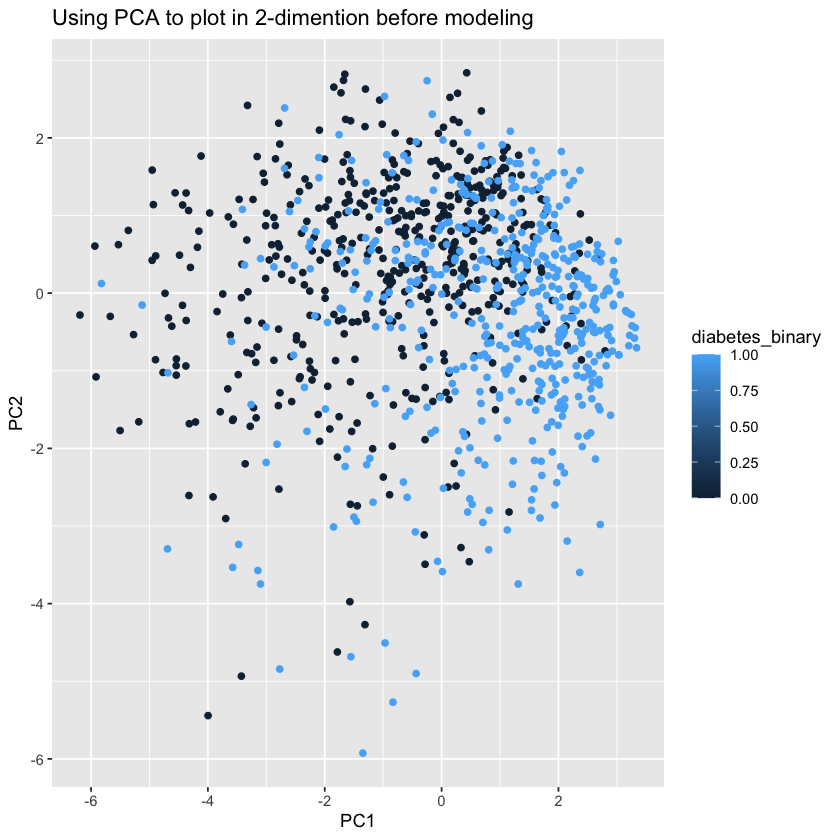

In [15]:
# Before selecting variables, visualize classification

# Change factor variables into numeric for visualization
factor_cols_all <- sapply(diab_samp, is.factor)

diab_vis_all <- diab_samp %>%
  mutate_if(factor_cols_all, as.integer)

selected_numeric_all <- diab_vis_all[, factor_cols_all]
selected_numeric_all <- selected_numeric_all - 1

diab_vis_all[, factor_cols_all] <- selected_numeric_all

# Perform PCA
pca_all <- prcomp(diab_vis_all[, -which(names(diab_vis_all) == 'diabetes_binary')], 
                  scale. = TRUE)

# Extract the first two principal components
pca_data_all <- as.data.frame(pca_all$x[, 1:2])
colnames(pca_data_all) <- c("PC1", "PC2")

# Add target variable for coloring
pca_data_all$diabetes_binary <- diab_vis_all$diabetes_binary

# Plot using ggplot
pca_vis_all <- ggplot(aes(x=PC1, y=PC2, color=diabetes_binary), 
                           data = pca_data_all) +
  geom_point() +
  ggtitle("Using PCA to plot in 2-dimention before modeling")

pca_vis_all


### Selecting columns part

In [11]:
col <- c("diabetes_binary","diff_walk", "heart_diseaseor_attack", "high_bp", "high_chol", "phys_activity", "bmi", "gen_hlth", "ment_hlth", "age", "smoker", "stroke") 

diab_sel <- diab_samp %>%
  select(col)

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(col)

  # Now:
  data %>% select(all_of(col))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


In [16]:
# Change factor variables into numeric for visualization for PCA
factor_cols <- sapply(diab_sel, is.factor)

diab_vis <- diab_sel %>%
  mutate_if(factor_cols, as.integer)

selected_numeric <- diab_vis[, factor_cols]
selected_numeric <- selected_numeric - 1

diab_vis[, factor_cols] <- selected_numeric


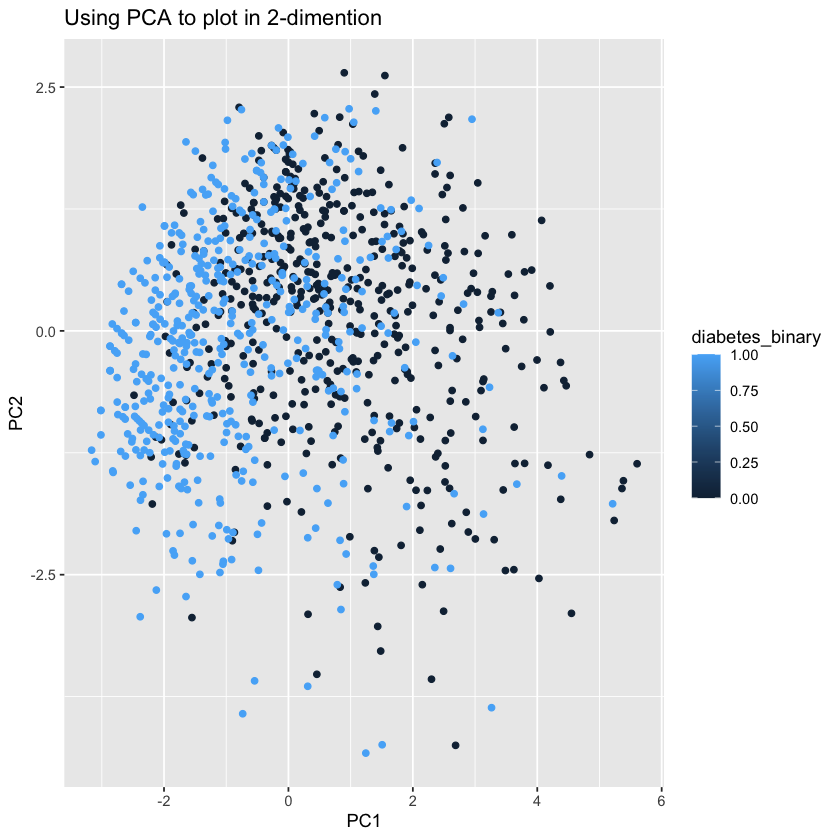

In [18]:
# Visualize data in 2-dimensions plot
# Perform PCA
pca <- prcomp(diab_vis[, -which(names(diab_vis) == 'diabetes_binary')], scale. = TRUE)

# Extract the first two principal components
pca_data <- as.data.frame(pca$x[, 1:2])
colnames(pca_data) <- c("PC1", "PC2")

# Add target variable for coloring
pca_data$diabetes_binary <- diab_vis$diabetes_binary

# Plot using ggplot
pca_vis <- ggplot(aes(x=PC1, y=PC2, color=diabetes_binary), data = pca_data) +
  geom_point() +
  ggtitle("Using PCA to plot in 2-dimention")

pca_vis
